# Tarea ML reto clase 1

## Importamos librerias

In [164]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier

# BU

Queremos saber e intentar predecir la calidad de sueño de las personas dada informacion dada por persona.

## Leemos los datos y checamos las primeras 5 filas

In [7]:
data = pd.read_csv('synthetic_coffee_health_10000.csv', index_col=0)
data.head()

,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
ID,,,,,,,,,,,,,,,
1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


## Informacion importante de los datos

Vemos que los unicos datos faltantes estan en Health_Issues y los rellenamos con "No"

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      10000 non-null  int64  
 1   Gender                   10000 non-null  object 
 2   Country                  10000 non-null  object 
 3   Coffee_Intake            10000 non-null  float64
 4   Caffeine_mg              10000 non-null  float64
 5   Sleep_Hours              10000 non-null  float64
 6   Sleep_Quality            10000 non-null  object 
 7   BMI                      10000 non-null  float64
 8   Heart_Rate               10000 non-null  int64  
 9   Stress_Level             10000 non-null  object 
 10  Physical_Activity_Hours  10000 non-null  float64
 11  Health_Issues            4059 non-null   object 
 12  Occupation               10000 non-null  object 
 13  Smoking                  10000 non-null  int64  
 14  Alcohol_Consumption      10

In [21]:
data['Health_Issues'].fillna('No', inplace=True)

In [22]:
data['Health_Issues'].value_counts()

Health_Issues
No          5941
Mild        3579
Moderate     463
Severe        17
Name: count, dtype: int64

## Separacion de los datos
### Transformamos la variable "y" a ordinal

In [92]:
X = data.drop('Sleep_Quality', axis=1)
y = data['Sleep_Quality']
le = LabelEncoder()
y = le.fit_transform(data['Sleep_Quality'])

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)

## Generamos nuestro preprocesador de los datos

In [165]:
cat_ordinal_cols = ['Stress_Level']
cat_onehot_cols = ['Gender', 'Country', 'Occupation']
num_cols = data.select_dtypes(include=['number']).columns

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ord_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('power', PowerTransformer(method='yeo-johnson'))
])

pre = ColumnTransformer(
    transformers=[
        ('cat_ordinal', ord_pipe, cat_ordinal_cols),
        ('cat_onehot', cat_pipe, cat_onehot_cols),
        ('num', num_pipe, num_cols)
    ]
)


## Iniciamos nuestro pipeline con XGBoostClassifier

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline(steps=[
    ('pre', pre),
    ('model', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42
    ))
])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.1, 0.05, 0.01],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


## Feature Importance

In [140]:
xgb_final = best_model.named_steps["model"]
importances = xgb_final.feature_importances_
feature_names = best_model.named_steps["pre"].get_feature_names_out()
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
feat_imp.head(15)

,Feature,Importance
0,cat_ordinal__Stress_Level,0.507519
32,num__Sleep_Hours,0.395285
31,num__Caffeine_mg,0.006654
30,num__Coffee_Intake,0.005661
5,cat_onehot__Country_Belgium,0.005147
4,cat_onehot__Country_Australia,0.004939
27,cat_onehot__Occupation_Service,0.003865
34,num__Heart_Rate,0.003828
19,cat_onehot__Country_Spain,0.003809
15,cat_onehot__Country_Mexico,0.003713


<Figure size 1000x600 with 0 Axes>

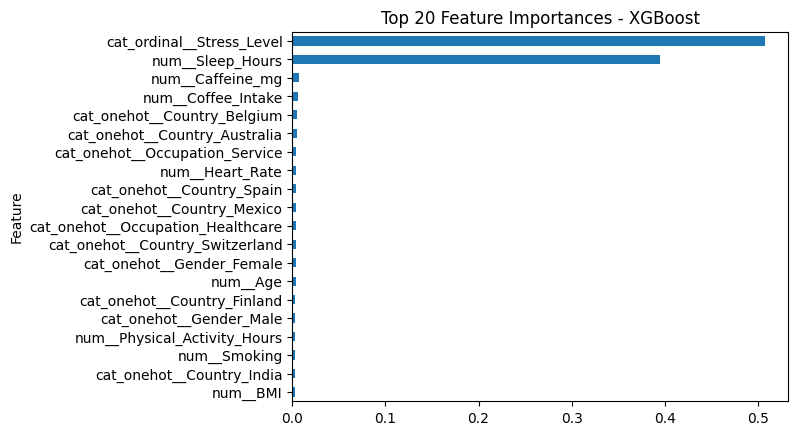

In [143]:
plt.figure(figsize=(10,6))
feat_imp.head(20).plot(kind="barh", x="Feature", y="Importance", legend=False)
plt.title("Top 20 Feature Importances - XGBoost")
plt.gca().invert_yaxis()
plt.show()

In [155]:
selector = SelectFromModel(
    estimator=XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        n_estimators=300,    
        max_depth=4,
        tree_method="hist",
        threshold=-np.inf,
        verbosity=0
    ),
    threshold=-np.inf,       
    max_features=None,        
    importance_getter="auto"  
)

pipe_fs = Pipeline(steps=[
    ('pre', pre),
    ('select', selector),
    ('model', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        tree_method="hist",
        verbosity=0
    ))
])

param_grid_fs = {
    'select__max_features': [10,38],
    'model__n_estimators': [200, 400, 700],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.1, 0.05, 0.02],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_fs = GridSearchCV(
    estimator=pipe_fs,
    param_grid=param_grid_fs,
    scoring='neg_log_loss', 
    cv=cv,
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

grid_fs.fit(X_train, y_train)

best_fs = grid_fs.best_estimator_
print("Mejor combinación:", grid_fs.best_params_)

y_pred = best_fs.predict(X_test)
y_proba = best_fs.predict_proba(X_test)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejor combinación: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 1.0, 'select__max_features': 38}


## Vemos los resultados

In [156]:
print("Mapeo de Clases:")
print(le.classes_)
print(np.unique(y), end='\n\n')
print('=======================================================')
print("Accuracy Score!:", accuracy_score(y_test, y_pred))
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score!:", f1)
print(classification_report(y_test, y_pred))
print('=======================================================')

Mapeo de Clases:
['Excellent' 'Fair' 'Good' 'Poor']
[0 1 2 3]

Accuracy Score!: 0.99
F1 Score!: 0.989985916873198
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       273
           1       1.00      1.00      1.00       375
           2       0.99      0.99      0.99      1162
           3       1.00      1.00      1.00       190

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



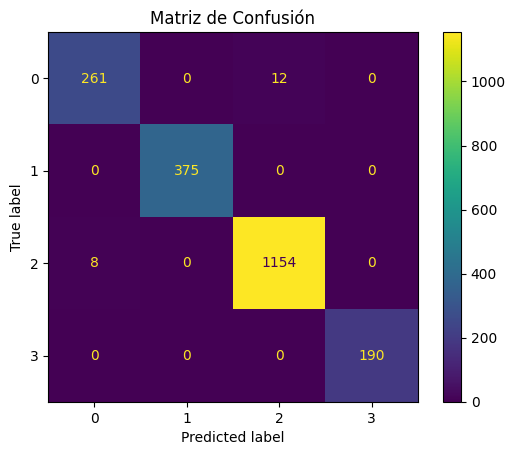

In [157]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Matriz de Confusión')
plt.show()

# RED Neuronal

In [190]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import seaborn as sns
import pandas as pd
import numpy as np

In [166]:
pre

,transformers,"[('cat_ordinal', ...), ('cat_onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None


In [178]:
X = data.drop('Sleep_Quality', axis=1)
y = data['Sleep_Quality']
le = LabelEncoder()
y = le.fit_transform(data['Sleep_Quality'])
X = pre.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)

In [181]:
np.unique(y_train)

array([0, 1, 2, 3])

In [185]:
nw = Sequential(
    [
        Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(8, activation='relu'),
        Dense(4, activation='relu'),
        Dense(np.unique(y_train).shape[0], activation='softmax')
    ]
)

nw.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

nw.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

y_pred_probs = nw.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("Accuracy Score!:", accuracy_score(y_test, y_pred_classes))
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print("F1 Score!:", f1)
print(classification_report(y_test, y_pred_classes))

Epoch 1/20


/Users/yosesotomayor/Code/IA-Concentracion/reto/.reto/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6015 - loss: 1.0197 - val_accuracy: 0.7820 - val_loss: 0.6574
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.8485 - loss: 0.4457 - val_accuracy: 0.8745 - val_loss: 0.3080
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.9247 - loss: 0.2193 - val_accuracy: 0.9755 - val_loss: 0.1393
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.9854 - loss: 0.0919 - val_accuracy: 0.9850 - val_loss: 0.0669
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.9894 - loss: 0.0534 - val_accuracy: 0.9890 - val_loss: 0.0479
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.9901 - loss: 0.0394 - val_accuracy: 0.9885 - val_loss: 0.0394
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.9906 - loss: 0.0325 - val_accuracy: 0.9885 - val_loss: 0.0334
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - accuracy: 0.9912 - loss: 0.0280 - val_accuracy:

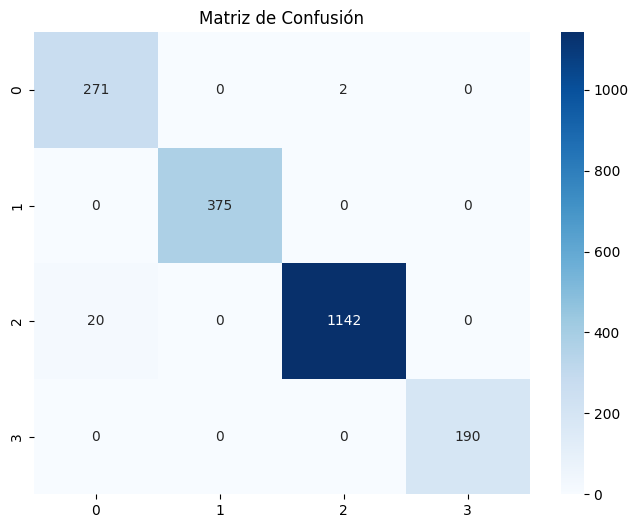

In [191]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusión')
plt.show()